# Object Localization

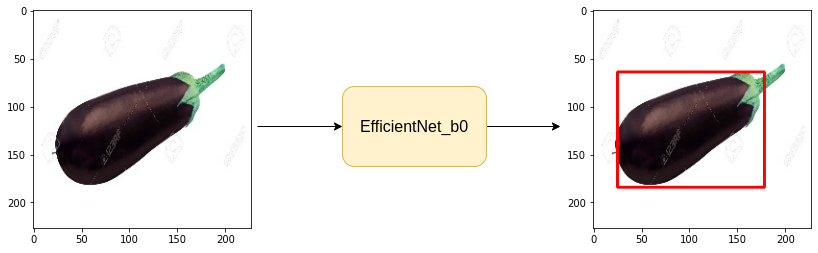

In [42]:
# install libraries/packages/modules

#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install timm
#!pip install --upgrade opencv-contrib-python

In [43]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [44]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [45]:
import sys
sys.path.append('object-localization-dataset')

# Configurations

In [46]:
CSV_FILE = 'object-localization-dataset/train.csv'
DATA_DIR = 'object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'resnet50'

# number of coordinates
NUM_COR = 4

# Understand the dataset

In [47]:
# loading the data from the CSV file
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


In [48]:
row = df.iloc[2]
DATA_DIR + row.img_path

'object-localization-dataset/train_images/mushroom_20.jpg'

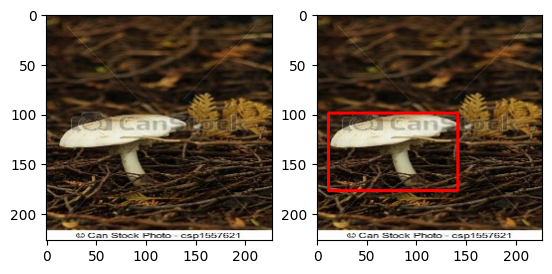

In [49]:
# selecting a row from the dataframe
row = df.iloc[34]
# using the img_path data to create the image path
img = cv2.imread(DATA_DIR + row.img_path)
# changing the color space of the image from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# showing only the image
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)

# extracting the points for the bounding box
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
# setting the bounding box
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2) 
# showing the image with its bounding box
ax2.imshow(bnd_box_img)

In [50]:
# Spliting the data set. Since it dataset is small (185 images), the validation set will be used for testing.

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [51]:
import albumentations as A

In [52]:
# train augmentation

train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [53]:
# validation augementation

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [54]:


class ObjLocDataset(torch.utils.data.Dataset):

    def __init__(self, dataframe, aumens = None):
        self.df = dataframe
        self.aumentations = aumens

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row_df = self.df.iloc[idx]

        xmin = row_df.xmin
        ymin = row_df.ymin
        xmax = row_df.xmax
        ymax = row_df.ymax

        bbox_in = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR + row_df.img_path
        img_in = cv2.imread(img_path)
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)

        if self.aumentations:
            data = self.aumentations(image=img_in, bboxes=bbox_in, class_labels=[None])
            img_in = data['image']
            bbox_in = data['bboxes'][0]

        img_in = torch.from_numpy(img_in).permute(2,0,1)/ 255.0 # (h,w,c) -> (c,h,w)
        bbox_in = torch.Tensor(bbox_in)

        return img_in, bbox_in

In [55]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [56]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


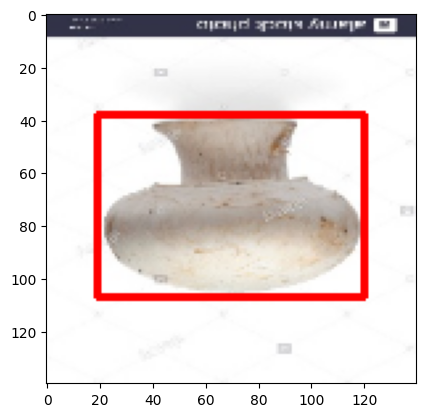

In [57]:
img, bbox = trainset[8]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [58]:
# loading traindataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
# loading validation dataset
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [59]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [60]:
for images, bboxes in trainloader:
    break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [61]:
from torch import nn
import timm

In [62]:
#

class ObjLocModel(nn.Module):

    def __init__(self,
                 model_name: str = MODEL_NAME,
                 output_dim: int=NUM_COR,
                 pretrained: bool=True,
                 loss_fn: nn.Module=None):
        super(ObjLocModel,self).__init__()
        # instantiation backbone with a new head
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=output_dim)
        self.criterion = loss_fn or nn.MSELoss()

    def forward(self, images, gt_bboxes=None):
        preds = self.backbone(images)

        if gt_bboxes is not None:
            loss = self.criterion(preds, gt_bboxes)
            return preds, loss
            
        return preds

In [63]:
model = ObjLocModel()
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

ObjLocModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

In [64]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [65]:
# training function

def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() # this mean that Dropout ON
    for data in tqdm(dataloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss/len(dataloader)

In [66]:
# evaluation function

def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() # this mean that Dropout OFF
    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

    return total_loss/len(dataloader)

# Training Loop

# Training Loop

In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [68]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)
    if valid_loss < train_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss
    print(f"Epoch: {i + 1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 1 train loss: 7500.207177734375 valid loss: 6918.31884765625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 2 train loss: 6978.67880859375 valid loss: 6144.285970052083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 3 train loss: 6346.137353515625 valid loss: 5023.28857421875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 4 train loss: 5093.510205078125 valid loss: 2499.3680013020835


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 5 train loss: 3642.973779296875 valid loss: 1290.0243733723958


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 6 train loss: 2017.1304443359375 valid loss: 620.1291198730469


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 7 train loss: 900.4326446533203 valid loss: 517.038330078125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 train loss: 289.499089050293 valid loss: 346.765869140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 train loss: 222.3060272216797 valid loss: 359.9308369954427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 train loss: 231.03006744384766 valid loss: 314.87945556640625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 train loss: 191.4794692993164 valid loss: 220.43372599283853


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 train loss: 206.94709548950195 valid loss: 225.52342224121094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 train loss: 179.72686614990235 valid loss: 203.3801727294922


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 train loss: 169.93301010131836 valid loss: 204.0406239827474


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 train loss: 154.0957046508789 valid loss: 199.75829060872397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 train loss: 159.5841064453125 valid loss: 181.5693613688151


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 train loss: 134.96214218139647 valid loss: 162.64176432291666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 18 train loss: 152.8552734375 valid loss: 148.94303385416666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 train loss: 111.22140884399414 valid loss: 120.53794606526692


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 train loss: 105.57405471801758 valid loss: 109.91253662109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 train loss: 103.76895065307617 valid loss: 119.57745615641277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 train loss: 112.3785774230957 valid loss: 116.23538716634114


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 23 train loss: 101.23023986816406 valid loss: 99.78900655110677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 train loss: 79.88070869445801 valid loss: 95.55670166015625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 train loss: 84.892041015625 valid loss: 93.91976674397786


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 26 train loss: 87.00659828186035 valid loss: 82.06605529785156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 27 train loss: 86.70731048583984 valid loss: 81.6258061726888


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 28 train loss: 87.06498260498047 valid loss: 76.82408396402995


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 train loss: 63.86289024353027 valid loss: 75.24156188964844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 train loss: 71.46114387512208 valid loss: 95.90360260009766


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 31 train loss: 73.90437088012695 valid loss: 72.83372497558594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 32 train loss: 72.5012363433838 valid loss: 72.36155700683594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 train loss: 70.75969314575195 valid loss: 73.94219462076823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 train loss: 70.40660018920899 valid loss: 77.99600474039714


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 train loss: 64.98712425231933 valid loss: 70.87242889404297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 36 train loss: 72.21689872741699 valid loss: 66.1048469543457


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 train loss: 65.01674385070801 valid loss: 76.27260080973308


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 38 train loss: 69.83036460876465 valid loss: 67.28986231486003


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 train loss: 65.95724830627441 valid loss: 69.26463826497395


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 train loss: 60.84083976745605 valid loss: 82.84967041015625


# Inference

In [69]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


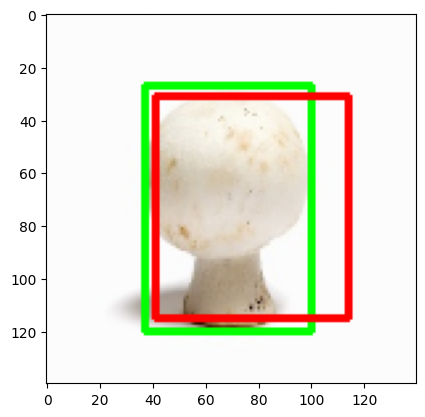

In [73]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[34] # (c, h, w)
    image = image.unsqueeze(0).to(DEVICE) # (bs, c, h, w)
    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)